The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 950 kB/s 
     |████████████████████████████████| 120 kB 29.9 MB/s 
     |████████████████████████████████| 1.6 MB 58.1 MB/s 
     |████████████████████████████████| 82 kB 976 kB/s 


# Deep Convolutional Neural Networks (AlexNet)
:label:`sec_alexnet`


Although CNNs were well known
in the computer vision and machine learning communities
following the introduction of LeNet :cite:`LeCun.Jackel.Bottou.ea.1995`,
they did not immediately dominate the field.
Although LeNet achieved good results on early small datasets,
the performance and feasibility of training CNNs
on larger, more realistic datasets had yet to be established.
In fact, for much of the intervening time between the early 1990s
and the watershed results of 2012 :cite:`Krizhevsky.Sutskever.Hinton.2012`,
neural networks were often surpassed by other machine learning methods,
such as kernel methods :cite:`Scholkopf.Smola.2002`, ensemble methods :cite:`Freund.Schapire.ea.1996`,
and structured estimation :cite:`Taskar.Guestrin.Koller.2004`.

For computer vision, this comparison is perhaps not entirely accurate.
That is, although the inputs to convolutional networks
consist of raw or lightly-processed (e.g., by centering) pixel values, practitioners would never feed raw pixels into traditional models.
Instead, typical computer vision pipelines
consisted of manually engineering feature extraction pipelines, such as SIFT :cite:`Lowe.2004`, SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`, and bags of visual words :cite:`Sivic.Zisserman.2003`.
Rather than *learning* the features, the features were *crafted*.
Most of the progress came from having more clever ideas for feature extraction on the one hand and deep insight into geometry :cite:`Hartley.Zisserman.2000` on the other hand. The learning algorithm was often considered an afterthought.

Although some neural network accelerators were available in the 1990s,
they were not yet sufficiently powerful to make
deep multichannel, multilayer CNNs
with a large number of parameters. For instance, NVIDIA's GeForce 256 from 1999
was able to process at most 480 million operations per second (MFLOPs), without any meaningful
programming framework for operations beyond games. Today's accelerators are able to perform in excess of 300 TFLOPs per device (NVIDIA's Ampere A100). 
Note that *FLOPs*
are floating-point operations such as multiplications and additions.
Moreover, datasets were still relatively small: OCR on 60,000 low-resolution $28 \times 28$ pixel images was considered a highly challenging task.
Added to these obstacles, key tricks for training neural networks
including parameter initialization heuristics :cite:`Glorot.Bengio.2010`,
clever variants of stochastic gradient descent :cite:`Kingma.Ba.2014`,
non-squashing activation functions :cite:`Nair.Hinton.2010`,
and effective regularization techniques :cite:`Srivastava.Hinton.Krizhevsky.ea.2014` were still missing.

Thus, rather than training *end-to-end* (pixel to classification) systems,
classical pipelines looked more like this:

1. Obtain an interesting dataset. In the early days, these datasets required expensive sensors. For instance, the [Apple QuickTake 100](https://en.wikipedia.org/wiki/Apple_QuickTake) of 1994 sported a whopping 0.3 Megapixel (VGA) resolution, capable of storing up to 8 images, all for the price of \$1,000.
1. Preprocess the dataset with hand-crafted features based on some knowledge of optics, geometry, other analytic tools, and occasionally on the serendipitous discoveries of lucky graduate students.
1. Feed the data through a standard set of feature extractors such as the SIFT (scale-invariant feature transform) :cite:`Lowe.2004`, the SURF (speeded up robust features) :cite:`Bay.Tuytelaars.Van-Gool.2006`, or any number of other hand-tuned pipelines. OpenCV still provides SIFT extractors to this day! 
1. Dump the resulting representations into your favorite classifier, likely a linear model or kernel method, to train a classifier.

If you spoke to machine learning researchers,
they believed that machine learning was both important and beautiful.
Elegant theories proved the properties of various classifiers :cite:`Boucheron.Bousquet.Lugosi.2005` and convex
optimization :cite:`Boyd.Vandenberghe.2004` had become the mainstay for obtaining them.
The field of machine learning was thriving, rigorous, and eminently useful. However,
if you spoke to a computer vision researcher,
you would hear a very different story.
The dirty truth of image recognition, they would tell you,
is that features, geometry :cite:`Hartley.Zisserman.2000,hartley2009global`, and engineering,
rather than novel learning algorithms, drove progress.
Computer vision researchers justifiably believed
that a slightly bigger or cleaner dataset
or a slightly improved feature-extraction pipeline
mattered far more to the final accuracy than any learning algorithm.

## Representation Learning

Another way to cast the state of affairs is that
the most important part of the pipeline was the representation.
And up until 2012 the representation was calculated mostly mechanically.
In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper.
SIFT :cite:`Lowe.2004`,
SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`,
HOG (histograms of oriented gradient) :cite:`Dalal.Triggs.2005`,
bags of visual words :cite:`Sivic.Zisserman.2003`,
and similar feature extractors ruled the roost.

Another group of researchers,
including Yann LeCun, Geoff Hinton, Yoshua Bengio,
Andrew Ng, Shun-ichi Amari, and Juergen Schmidhuber,
had different plans.
They believed that features themselves ought to be learned.
Moreover, they believed that to be reasonably complex,
the features ought to be hierarchically composed
with multiple jointly learned layers, each with learnable parameters.
In the case of an image, the lowest layers might come
to detect edges, colors, and textures, in analogy to how the visual system in animals
processes its input. In particular, the automatic design of visual features such as those obtained
by sparse coding :cite:`olshausen1996emergence` remained an open challenge until the advent of modern CNNs. 
It was not until :citet:`dean2012large,le2013building` that the idea of generating features 
from image data automatically gained significant traction.

The first modern CNN :cite:`Krizhevsky.Sutskever.Hinton.2012`, named
*AlexNet* after one of its inventors, Alex Krizhevsky, is largely an evolutionary improvement
over LeNet. It achieved excellent performance in the 2012 ImageNet challenge.

![Image filters learned by the first layer of AlexNet. Reproduction courtesy of :citet:`Krizhevsky.Sutskever.Hinton.2012`.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/filters.png?raw=1)
:width:`400px`
:label:`fig_filters`

Interestingly in the lowest layers of the network,
the model learned feature extractors that resembled some traditional filters.
:numref:`fig_filters`
shows lower-level image descriptors.
Higher layers in the network might build upon these representations
to represent larger structures, like eyes, noses, blades of grass, and so on.
Even higher layers might represent whole objects
like people, airplanes, dogs, or frisbees.
Ultimately, the final hidden state learns a compact representation
of the image that summarizes its contents
such that data belonging to different categories can be easily separated.

AlexNet (2012) and its precursor LeNet (1995) share many architectural elements. This begs the question: why did it take so long?
A key difference is that over the past two decades, the amount of data and computing power available had increased significantly. As such AlexNet was much larger: it was trained on much more data, and on much faster GPUs, compared to the CPUs available in 1995.

### Missing Ingredient: Data

Deep models with many layers require large amounts of data
in order to enter the regime
where they significantly outperform traditional methods
based on convex optimizations (e.g., linear and kernel methods).
However, given the limited storage capacity of computers,
the relative expense of (imaging) sensors,
and the comparatively tighter research budgets in the 1990s,
most research relied on tiny datasets.
Numerous papers relied on the UCI collection of datasets,
many of which contained only hundreds or (a few) thousands of images
captured in low resolution and often with an artificially clean background.

In 2009, the ImageNet dataset was released :cite:`Deng.Dong.Socher.ea.2009`,
challenging researchers to learn models from 1 million examples,
1000 each from 1000 distinct categories of objects. The categories themselves
were based on the most popular noun nodes in WordNet :cite:`Miller.1995`.
The ImageNet team used Google Image Search to prefilter large candidate sets
for each category and employed
the Amazon Mechanical Turk crowdsourcing pipeline
to confirm for each image whether it belonged to the associated category.
This scale was unprecedented, exceeding others by over an order of magnitude
(e.g., CIFAR-100 has 60,000 images). Another aspect was that the images were at
relatively high resolution of $224 \times 224$ pixels, unlike the 80 million sized
TinyImages dataset :cite:`Torralba.Fergus.Freeman.2008`, consisting of $32 \times 32$ pixel thumbnails.
This allowed for the formation of higher-level features.
The associated competition, dubbed the ImageNet Large Scale Visual Recognition
Challenge :cite:`russakovsky2015imagenet`, 
pushed computer vision and machine learning research forward,
challenging researchers to identify which models performed best
at a greater scale than academics had previously considered. The largest vision datasets, such as LAION-5B 
:cite:`schuhmannlaion` contain billions of images with additional metadata.

### Missing Ingredient: Hardware

Deep learning models are voracious consumers of compute cycles.
Training can take hundreds of epochs, and each iteration
requires passing data through many layers of computationally-expensive
linear algebra operations.
This is one of the main reasons why in the 1990s and early 2000s,
simple algorithms based on the more-efficiently optimized
convex objectives were preferred.

*Graphical processing units* (GPUs) proved to be a game changer
in making deep learning feasible.
These chips had long been developed for accelerating
graphics processing to benefit computer games.
In particular, they were optimized for high throughput $4 \times 4$
matrix-vector products, which are needed for many computer graphics tasks.
Fortunately, the math is strikingly similar
to that required to calculate convolutional layers.
Around that time, NVIDIA and ATI had begun optimizing GPUs
for general computing operations :cite:`Fernando.2004`,
going as far as to market them as *general-purpose GPUs* (GPGPUs).

To provide some intuition, consider the cores of a modern microprocessor
(CPU).
Each of the cores is fairly powerful running at a high clock frequency
and sporting large caches (up to several megabytes of L3).
Each core is well-suited to executing a wide range of instructions,
with branch predictors, a deep pipeline, specialized execution units,
speculative execution,
and many other bells and whistles
that enable it to run a large variety of programs with sophisticated control flow.
This apparent strength, however, is also its Achilles heel:
general-purpose cores are very expensive to build. They excel at general-purpose
code with lots of control flow.
This requires lots of chip area, not just for the
actual ALU (arithmetic logical unit) where computation happens, but also for
all the aforementioned bells and whistles, plus
memory interfaces, caching logic between cores,
high-speed interconnects, and so on. CPUs are
comparatively bad at any single task when compared to dedicated hardware.
Modern laptops have 4--8 cores,
and even high-end servers rarely exceed 64 cores per socket,
simply because it is not cost-effective.

By comparison, GPUs can consist of thousands of small processing elements (NIVIDA's latest Ampere chips have up to 6912 CUDA cores), often grouped into larger groups (NVIDIA calls them warps).
The details differ somewhat between NVIDIA, AMD, ARM and other chip vendors. While each core is relatively weak,
running at about 1GHz clock frequency,
it is the total number of such cores that makes GPUs orders of magnitude faster than CPUs.
For instance, NVIDIA's recent Ampere A100 GPU offers over 300 TFLOPs per chip for specialized 16 bit precision (BFLOAT16) matrix-matrix multiplications, and up to 20 TFLOPs for more general-purpose floating point operations (FP32).
At the same time, floating point performance of CPUs rarely exceeds 1 TFLOPs. For instance, Amazon's Graviton 3  reaches 2 TFLOPs peak performance for 16 bit precision operations, a number similar to the GPU performance of Apple's M1 processor. 

There are many reasons why GPUs are much faster than CPUs in terms of FLOPs. 
First, power consumption tends to grow *quadratically* with clock frequency.
Hence, for the power budget of a CPU core that runs 4 times faster (a typical number),
you can use 16 GPU cores at $\frac{1}{4}$ the speed,
which yields $16 \times \frac{1}{4} = 4$ times the performance.
Second, GPU cores are much simpler
(in fact, for a long time they were not even *able*
to execute general-purpose code),
which makes them more energy efficient. For instance, (i) they tend not to support speculative evaluation, (ii) it typically isn't possible to program each processing element individually, and (iii) the caches per core tend to be much smaller.
Last, many operations in deep learning require high memory bandwidth.
Again, GPUs shine here with buses that are at least 10 times as wide as many CPUs.

Back to 2012. A major breakthrough came
when Alex Krizhevsky and Ilya Sutskever
implemented a deep CNN
that could run on GPUs.
They realized that the computational bottlenecks in CNNs,
convolutions and matrix multiplications,
are all operations that could be parallelized in hardware.
Using two NVIDIA GTX 580s with 3GB of memory, either of which was capable of 1.5 TFLOPs (still a challenge for most CPUs a decade later),
they implemented fast convolutions.
The [cuda-convnet](https://code.google.com/archive/p/cuda-convnet/) code
was good enough that for several years
it was the industry standard and powered
the first couple years of the deep learning boom.

## AlexNet

AlexNet, which employed an 8-layer CNN,
won the ImageNet Large Scale Visual Recognition Challenge 2012
by a large margin :cite:`Russakovsky.Deng.Huang.ea.2013`.
This network showed, for the first time,
that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

The architectures of AlexNet and LeNet are strikingly similar,
as :numref:`fig_alexnet` illustrates.
Note that we provide a slightly streamlined version of AlexNet
removing some of the design quirks that were needed in 2012
to make the model fit on two small GPUs.

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

There are also significant differences between AlexNet and LeNet.
First, AlexNet is much deeper than the comparatively small LeNet5.
AlexNet consists of eight layers: five convolutional layers,
two fully connected hidden layers, and one fully connected output layer.
Second, AlexNet used the ReLU instead of the sigmoid
as its activation function. Let's delve into the details below.

### Architecture

In AlexNet's first layer, the convolution window shape is $11\times11$.
Since the images in ImageNet are eight times higher and wider
than the MNIST images,
objects in ImageNet data tend to occupy more pixels with more visual detail.
Consequently, a larger convolution window is needed to capture the object.
The convolution window shape in the second layer
is reduced to $5\times5$, followed by $3\times3$.
In addition, after the first, second, and fifth convolutional layers,
the network adds max-pooling layers
with a window shape of $3\times3$ and a stride of 2.
Moreover, AlexNet has ten times more convolution channels than LeNet.

After the last convolutional layer, there are two huge fully connected layers
with 4096 outputs.
These layers require nearly 1GB model parameters.
Due to the limited memory in early GPUs,
the original AlexNet used a dual data stream design,
so that each of their two GPUs could be responsible
for storing and computing only its half of the model.
Fortunately, GPU memory is comparatively abundant now,
so we rarely need to break up models across GPUs these days
(our version of the AlexNet model deviates
from the original paper in this aspect).

### Activation Functions

Besides, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function.
 On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1 (:numref:`subsec_activation-functions`). Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

### Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully connected layer
by dropout (:numref:`sec_dropout`),
while LeNet only uses weight decay.
To augment the data even further, the training loop of AlexNet
added a great deal of image augmentation,
such as flipping, clipping, and color changes.
This makes the model more robust and the larger sample size effectively reduces overfitting.
We will discuss data augmentation in greater detail in :numref:`sec_image_augmentation`. See also :cite:`Buslaev.Iglovikov.Khvedchenya.ea.2020` for an in-depth review of such preprocessing steps.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

We [**construct a single-channel data example**] with both height and width of 224 (**to observe the output shape of each layer**). It matches the AlexNet architecture in :numref:`fig_alexnet`.


In [4]:
AlexNet().layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## Training

Although AlexNet was trained on ImageNet in :cite:`Krizhevsky.Sutskever.Hinton.2012`,
we use Fashion-MNIST here
since training an ImageNet model to convergence could take hours or days
even on a modern GPU.
One of the problems with applying AlexNet directly on [**Fashion-MNIST**]
is that its (**images have lower resolution**) ($28 \times 28$ pixels)
(**than ImageNet images.**)
To make things work, (**we upsample them to $224 \times 224$**).
This is generally not a smart practice, as it simply increases the computational 
complexity without adding information. Nonetheless, we do it here to be faithful to the AlexNet architecture.
We perform this resizing with the `resize` argument in the `d2l.FashionMNIST` constructor.

Now, we can [**start training AlexNet.**]
Compared to LeNet in :numref:`sec_lenet`,
the main change here is the use of a smaller learning rate
and much slower training due to the deeper and wider network,
the higher image resolution, and the more costly convolutions.


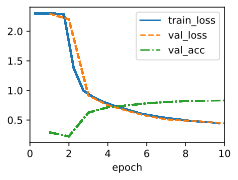

In [5]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## Discussion

AlexNet's structure bears a striking resemblance to LeNet, with a number of critical improvements, both for accuracy (dropout) and for ease of training (ReLU). What is equally striking is the amount of progress that has been made in terms of deep learning tooling. What was several months of work in 2012 can now be accomplished in a dozen lines of code using any modern framework.

Reviewing the architecture, we see that AlexNet has an Achilles heel when it comes to efficiency: the last two hidden layers require matrices of size $6400 \times 4096$ and $4096 \times 4096$, respectively. This corresponds to 164 MB of memory and 81 MFLOPs of computation, both of which are a nontrivial outlay, especially on smaller devices, such as mobile phones. This is one of the reasons why AlexNet has been surpassed by much more effective architectures that we will cover in the following sections. Nonetheless, it is a key step from shallow to deep networks that are used nowadays. Note that even though the number of parameters by far exceeds the amount of training data in our experiments (the last two layers have more than 40 million parameters, trained on a datasets of 60 thousand images), there is hardly any overfitting: training and validation loss are virtually identical throughout training. This is due to the improved regularization, such as Dropout, inherent in modern deep network designs. 

Although it seems that there are only a few more lines in AlexNet's implementation than in LeNet's, it took the academic community many years to embrace this conceptual change and take advantage of its excellent experimental results. This was also due to the lack of efficient computational tools. At the time neither DistBelief :cite:`Dean.Corrado.Monga.ea.2012` nor Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014` existed, and Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010` still lacked many distinguishing features. It is only the availability of TensorFlow :cite:`Abadi.Barham.Chen.ea.2016` that changed this situation dramatically.

## Exercises

1. Following up on the discussion above, analyze the computational properties of AlexNet.
    1. Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?
    1. Calculate the computational cost for the convolutions and the fully connected layers.
    1. How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?
1. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?
1. Why do engineers no longer report performance benchmarks on AlexNet?
1. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?
1. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.
    1. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.
    1. Design a better model that works directly on $28 \times 28$ images.
1. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.
1. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?
1. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?


[Discussions](https://discuss.d2l.ai/t/76)
